In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [87]:
train_file_path = "/kaggle/input/playground-series-s4e11/train.csv"
test_file_path = "/kaggle/input/playground-series-s4e11/test.csv"

In [88]:
trainingset = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(trainingset.shape))

Full train dataset shape is (140700, 20)


In [89]:
trainingset.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [90]:
trainingset.drop(columns='Name', inplace=True)
#first names so family groups cannot be created

In [91]:
numeric_columns = trainingset.select_dtypes(include='number').columns
categorical_columns = trainingset.select_dtypes(include='object').columns
numeric_columns = numeric_columns.drop(['id', 'Depression'])

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

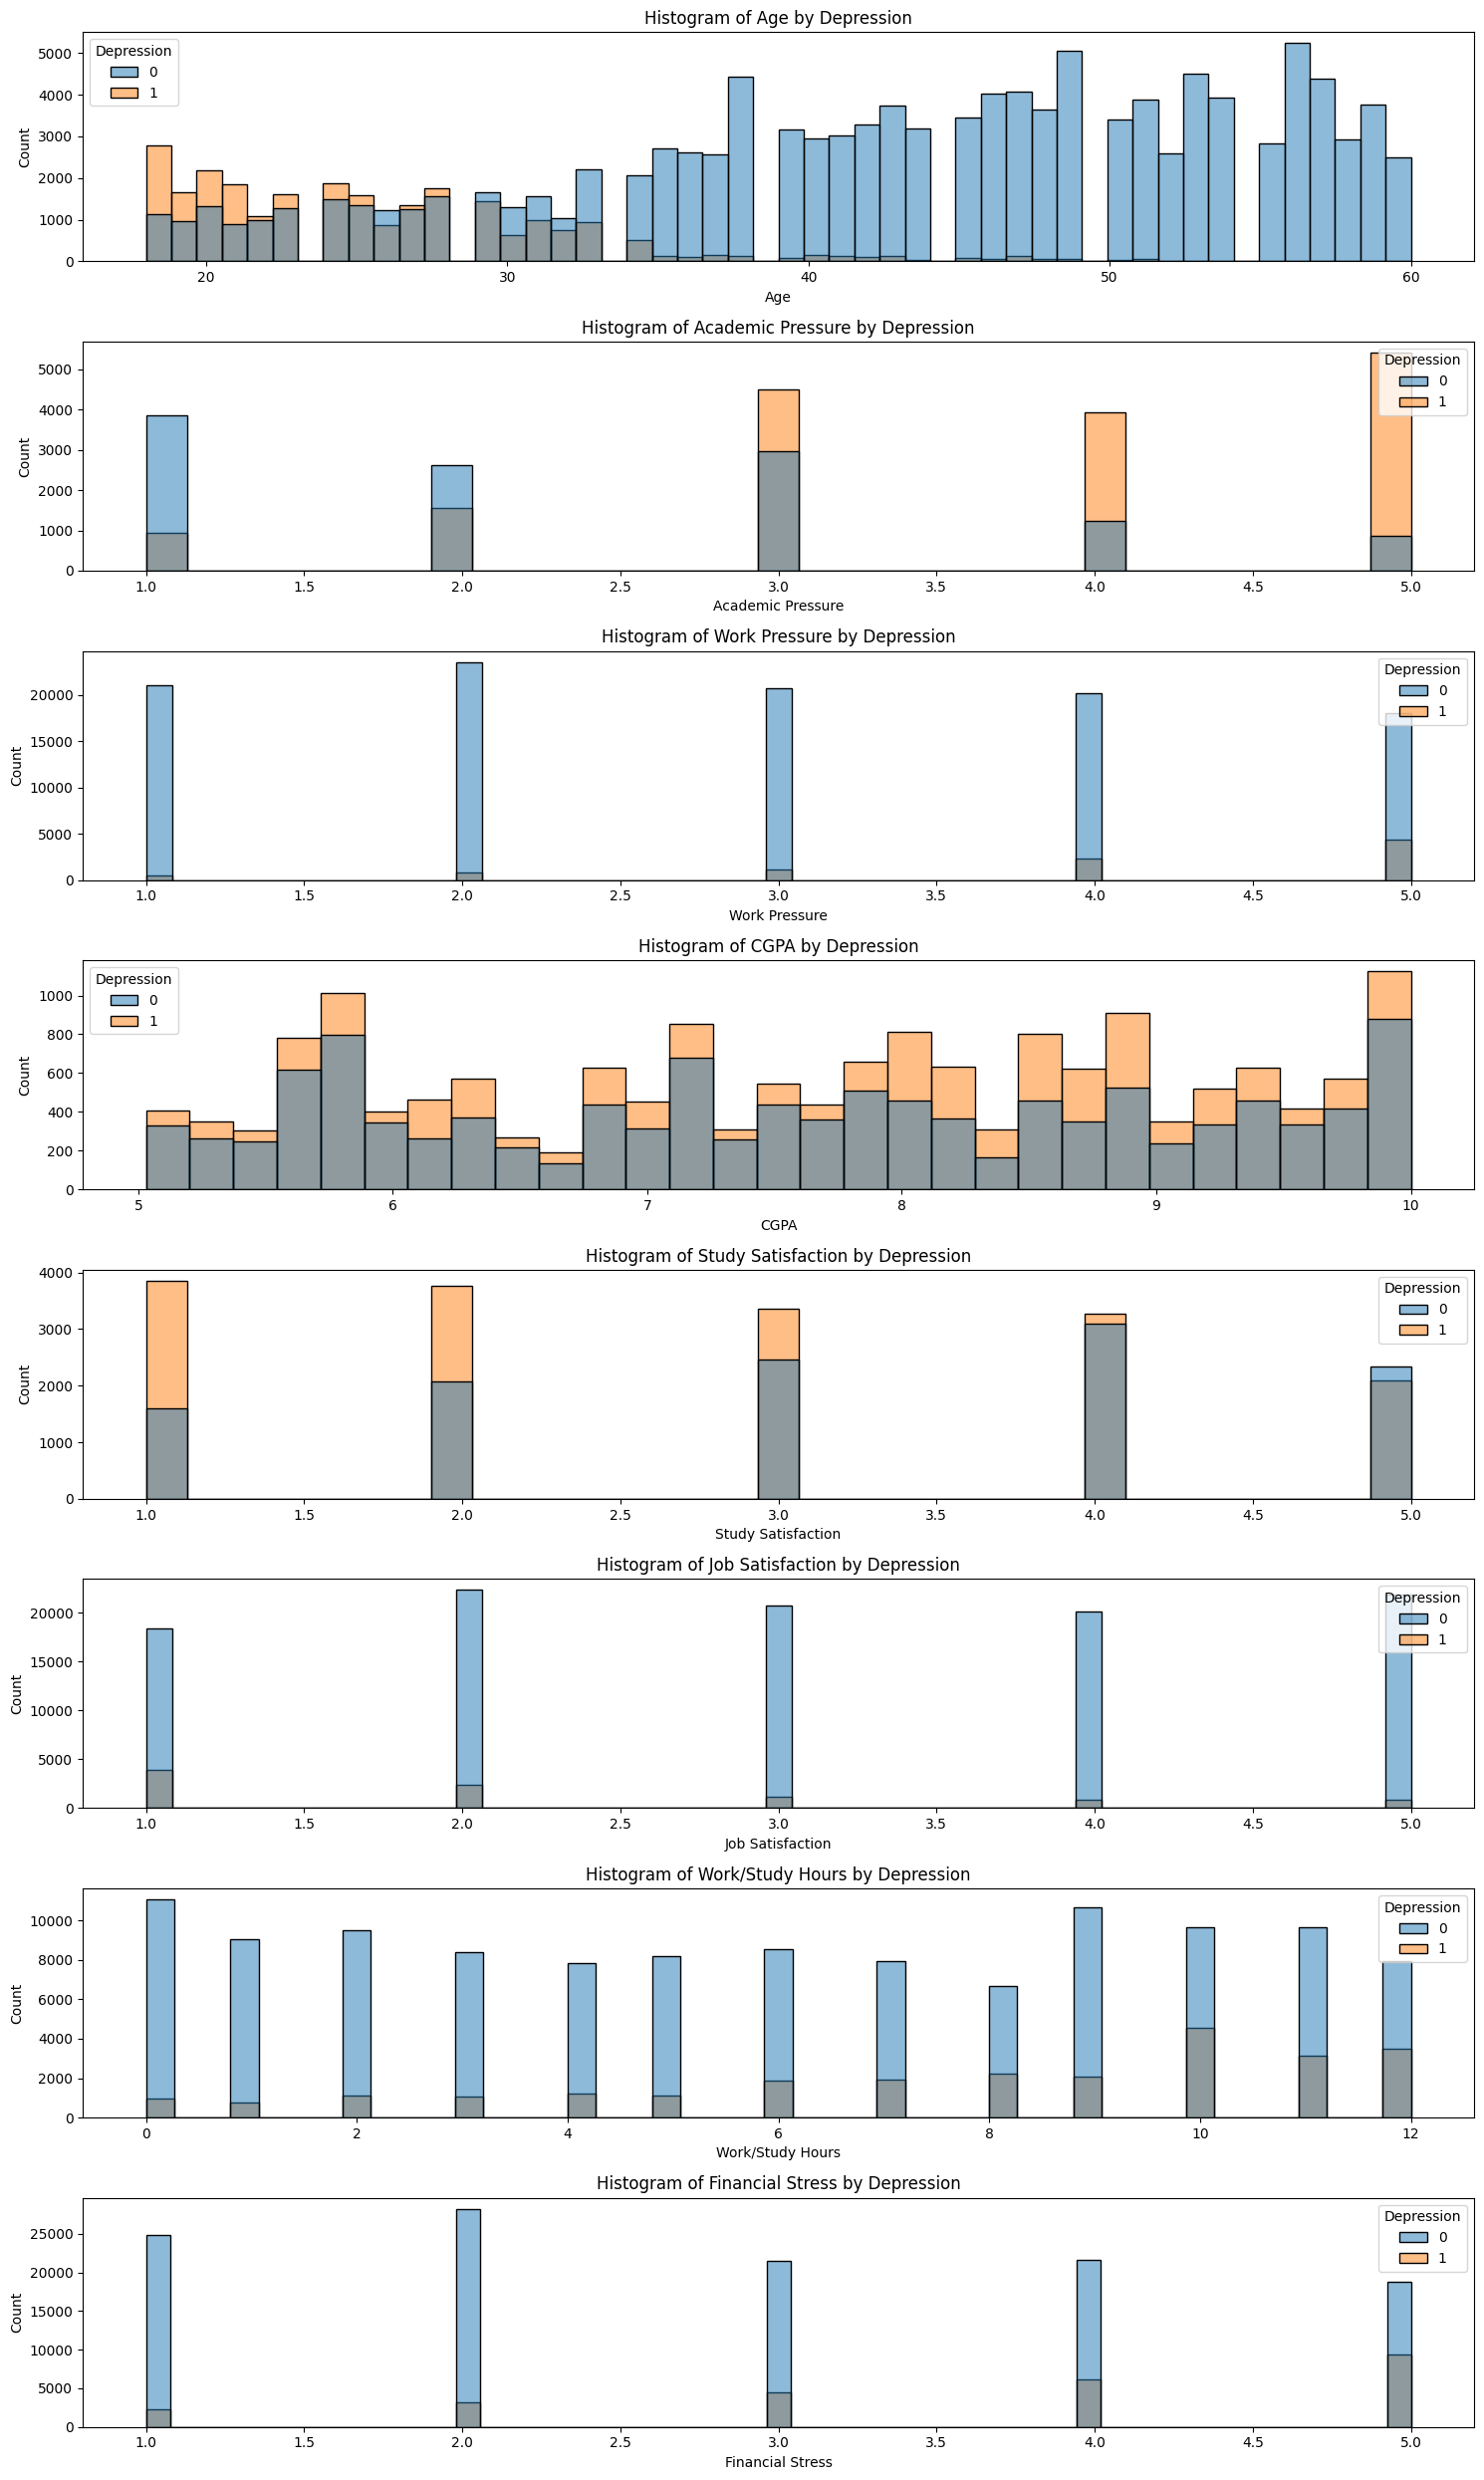

In [93]:
fig, ax = plt.subplots(len(numeric_columns), 1, figsize=(15,25), layout='compressed')

for i, j in enumerate(numeric_columns):
    
    sns.histplot(data = trainingset, x = j, hue = 'Depression', ax=ax[i])
    ax[i].set_title(f'Histogram of {j} by Depression')
plt.tight_layout()
plt.show()

In [94]:
corr = trainingset.select_dtypes(include='number').corr()
corr.style.background_gradient(cmap='coolwarm')

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
id,1.000000,0.001850,0.005597,0.003086,-0.011869,0.007824,0.002774,0.002359,-0.000340,0.003944
Age,0.001850,1.000000,-0.075956,-0.098924,0.005129,0.008862,0.030793,-0.118356,-0.083589,-0.564671
Academic Pressure,0.005597,-0.075956,1.000000,nan,-0.025195,-0.112228,-1.000000,0.095650,0.152105,0.475037
Work Pressure,0.003086,-0.098924,nan,1.000000,nan,nan,-0.036958,-0.002808,0.024412,0.216634
CGPA,-0.011869,0.005129,-0.025195,nan,1.000000,-0.047078,1.000000,0.002875,0.006398,0.021729
Study Satisfaction,0.007824,0.008862,-0.112228,nan,-0.047078,1.000000,-1.000000,-0.036934,-0.065001,-0.168014
Job Satisfaction,0.002774,0.030793,-1.000000,-0.036958,1.000000,-1.000000,1.000000,-0.029227,-0.029160,-0.168543
Work/Study Hours,0.002359,-0.118356,0.095650,-0.002808,0.002875,-0.036934,-0.029227,1.000000,0.036134,0.191746
Financial Stress,-0.000340,-0.083589,0.152105,0.024412,0.006398,-0.065001,-0.029160,0.036134,1.000000,0.227237
Depression,0.003944,-0.564671,0.475037,0.216634,0.021729,-0.168014,-0.168543,0.191746,0.227237,1.000000


We can immediately see that there are some metrics that have a clear impact on the target. Age clearly has an impact and can probably be attributed to younger people possibly being more likely to divulge information about their mental health. This age divide can also be inferred by how study satisfaction plays a greater role than job satisfaction, with study satisfaction representing a younger group than job satisfaction. These insights can be used to generate new features.

Let's see how many NA values we have

In [95]:
trainingset.isna().sum()

id                                            0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

Most NA values can be attributed to the split between students or working professionals. These features can be combined or re-engineered to ensure no NA values present. 

Checking that there is no overlap on satisfaction/Pressure

In [96]:
trainingset[trainingset[['Study Satisfaction','Job Satisfaction']].notnull().all(1)]


,id,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
1428,1428,Male,29.0,Srinagar,Student,NaN,3.0,NaN,9.63,3.0,3.0,7-8 hours,Moderate,M.Pharm,No,8.0,5.0,No,0
116703,116703,Male,25.0,Bangalore,Student,NaN,4.0,NaN,9.44,5.0,2.0,Less than 5 hours,Unhealthy,PhD,Yes,4.0,1.0,No,1


As you can see there is an overlap in job/study satisfaction for a few students working jobs on the side. Since in this case the academic pressure/study satisfaction will be a more important factor (students are likely studying full time and working on the side) we can take the academic side of each feature and fill the nulls with work satisfaction.

In [97]:
trainingset.head()

,id,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [98]:
trainingset['Pressure'] = trainingset['Academic Pressure'].fillna(trainingset['Work Pressure'])
trainingset['Satisfaction'] = trainingset['Study Satisfaction'].fillna(trainingset['Job Satisfaction'])
trainingset.drop(columns = ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'], inplace=True)

We can now fill the profession feature to "Other" for professionals and "Student" for students where the feature is null

In [99]:
trainingset.loc[trainingset['Working Professional or Student'] == 'Working Professional', 'Profession'] = trainingset.loc[trainingset['Working Professional or Student'] == 'Working Professional', 'Profession'].fillna("Other")
trainingset.loc[trainingset['Working Professional or Student'] == 'Student', 'Profession'] = trainingset.loc[trainingset['Working Professional or Student'] == 'Student', 'Profession'].fillna("Student")


Should definitely change this to a np.select() use ^^

Sleep duration is a clear numerical column that has been converted to a categorical column, it will be easy to convert back:

In [100]:
trainingset['Sleep Duration'].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

In [101]:
sleepmap={
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        '8 hours':8,
        '10-6 hours':8,
        'Unhealthy':3,
        'Work_Study_Hours':6,
        '3-6 hours':3.5,
        '9-5':7,
        '9-5 hours':7,
}

In [102]:
trainingset['Average Sleep'] = trainingset['Sleep Duration'].map(sleepmap)

We are leaving the original column present as we can use this later to create a sleep consistency metric which could be useful

CGPA presents an interesting challenge for nulls. Since they're only present for students and the majority of those surveyed are professionals, there's many nulls. We can also see from the earlier histogram and correlation matrix that there's not a particularly clear trend for depression.

It might be worth leaving in the model for now in case new features can be created with high performing/stress students which could be an indicator for the target. However, the lack of correlation implies this might not be the case and perhaps dropping the feature is the best way forward

In [103]:
trainingset['CGPA'] = trainingset['CGPA'].fillna(trainingset['CGPA'].median())

Binary features can be easily label encoded as it will not suggest an order (any sort of correlation with target will be preserved in either order, just reversed)

In [104]:
thoughtsmap = {
    'Yes': 1,
    'No': 0
}
illnessmap = {
    'Yes': 1,
    'No': 0
}
professionalmap = {
    'Working Professional': 1,
    'Student': 0
}
gendermap = {
    'Male': 1,
    'Female' : 0,
}
trainingset['Have you ever had suicidal thoughts ?'] = trainingset['Have you ever had suicidal thoughts ?'].map(thoughtsmap)
trainingset['Family History of Mental Illness'] = trainingset['Family History of Mental Illness'].map(illnessmap)
trainingset['Working Professional or Student'] = trainingset['Working Professional or Student'].map(professionalmap)
trainingset['Gender'] = trainingset['Gender'].map(gendermap)

The mental illness and suicidal thoughts features could prove strong indicators, let's take a quick look at their correlation

In [105]:
corr2 = trainingset[['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Depression']].corr()
corr2.style.background_gradient(cmap='coolwarm')

,Have you ever had suicidal thoughts ?,Family History of Mental Illness,Depression
Have you ever had suicidal thoughts ?,1.000000,0.009289,0.349066
Family History of Mental Illness,0.009289,1.000000,0.016502
Depression,0.349066,0.016502,1.000000


Suprisingly the history of mental illness has a very poor apparent correlation to the target, but there is a weak link between the other two features

In [106]:
trainingset.head()

,id,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction,Average Sleep
0,0,0,49.0,Ludhiana,1,Chef,7.77,More than 8 hours,Healthy,BHM,0,1.0,2.0,0,0,5.0,2.0,9.0
1,1,1,26.0,Varanasi,1,Teacher,7.77,Less than 5 hours,Unhealthy,LLB,1,7.0,3.0,0,1,4.0,3.0,4.0
2,2,1,33.0,Visakhapatnam,0,Student,8.97,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1,5.0,2.0,5.5
3,3,1,22.0,Mumbai,1,Teacher,7.77,Less than 5 hours,Moderate,BBA,1,10.0,1.0,1,1,5.0,1.0,4.0
4,4,0,30.0,Kanpur,1,Business Analyst,7.77,5-6 hours,Unhealthy,BBA,1,9.0,4.0,1,0,1.0,1.0,5.5


Now we are left with the categorical columns, we can apply label/one-hot encoding if we believe a direct link to the target, or we could make use of target encoding

In [107]:
trainingset.select_dtypes(include='object').head(10)

,City,Profession,Sleep Duration,Dietary Habits,Degree
0,Ludhiana,Chef,More than 8 hours,Healthy,BHM
1,Varanasi,Teacher,Less than 5 hours,Unhealthy,LLB
2,Visakhapatnam,Student,5-6 hours,Healthy,B.Pharm
3,Mumbai,Teacher,Less than 5 hours,Moderate,BBA
4,Kanpur,Business Analyst,5-6 hours,Unhealthy,BBA
5,Ahmedabad,Finanancial Analyst,5-6 hours,Healthy,MCA
6,Thane,Chemist,7-8 hours,Moderate,MD
7,Nashik,Teacher,7-8 hours,Unhealthy,B.Pharm
8,Bangalore,Student,5-6 hours,Moderate,BSc
9,Patna,Electrician,5-6 hours,Healthy,ME


Text(0.5, 0, 'Degree')

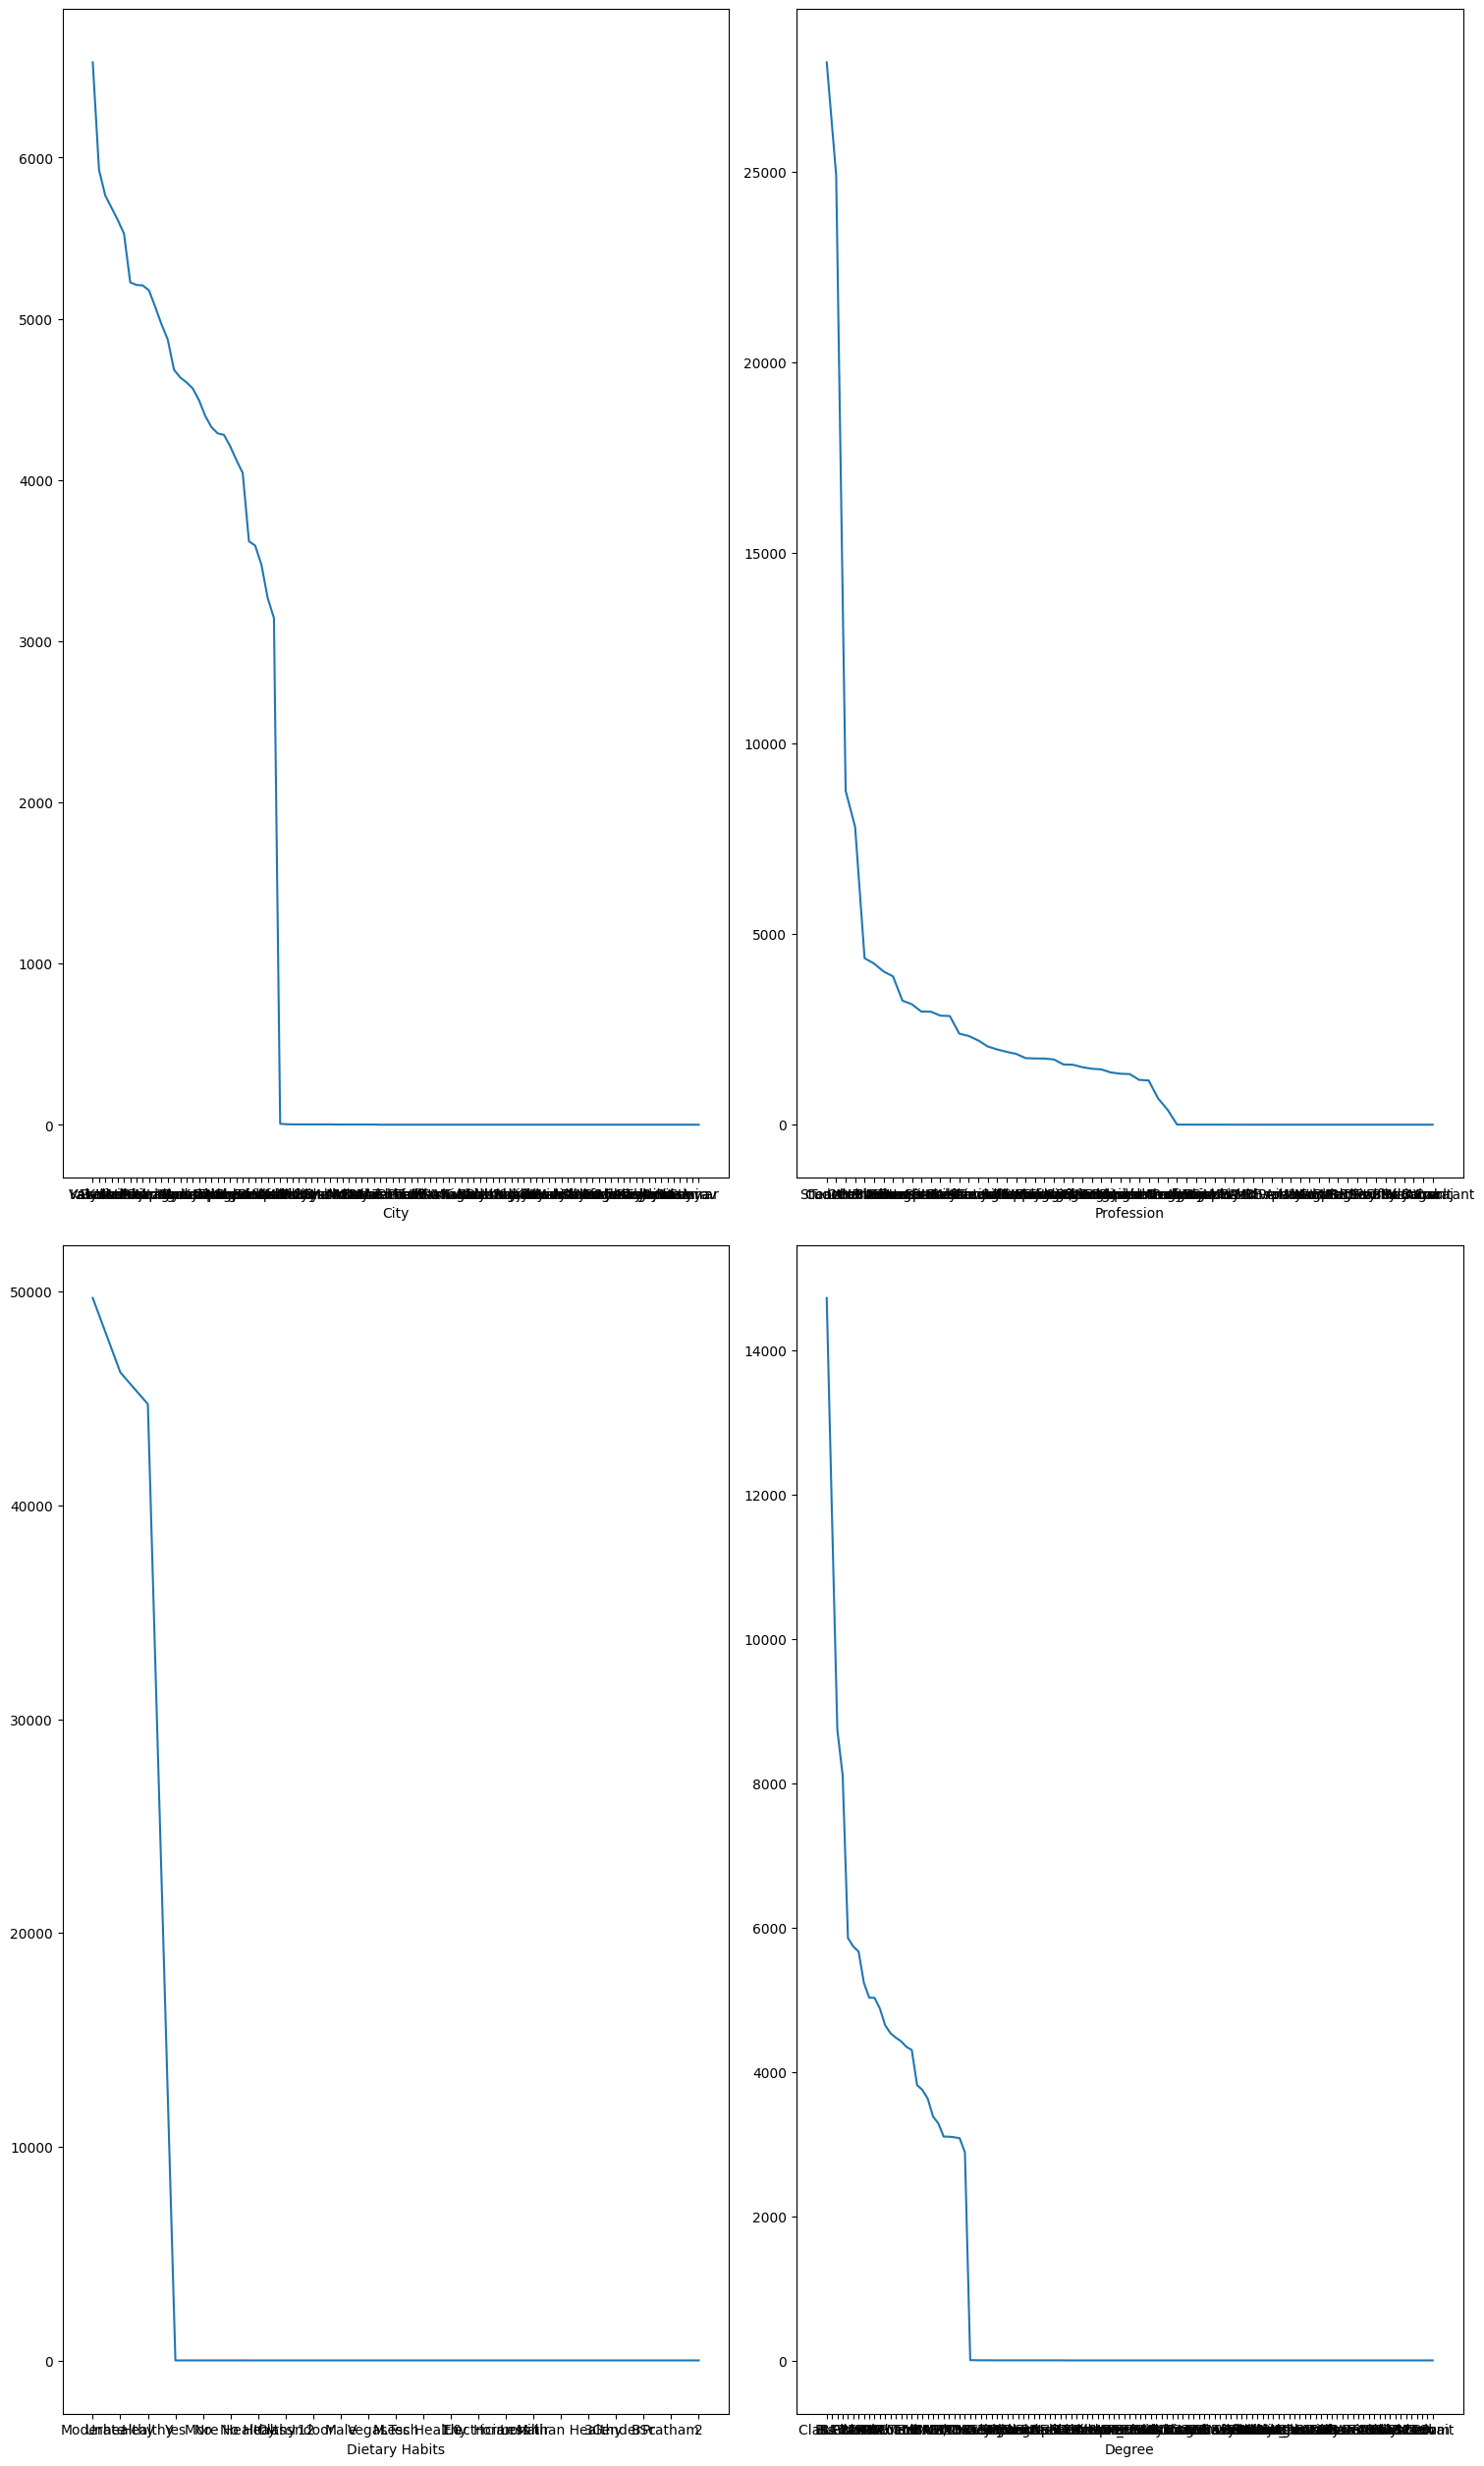

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(15,25), layout='compressed')
ax[0,0].plot(trainingset['City'].value_counts())
ax[0,1].plot(trainingset['Profession'].value_counts())
ax[1,0].plot(trainingset['Dietary Habits'].value_counts())
ax[1,1].plot(trainingset['Degree'].value_counts())
ax[0,0].set_xlabel('City')
ax[0,1].set_xlabel('Profession')
ax[1,0].set_xlabel('Dietary Habits')
ax[1,1].set_xlabel('Degree')



For the higher cardinality categorical columns, there is a large amount of noise (i.e cities that appear very few times and therefore will provide no or misleading information about the target)

We can change these rare entries to "Other" to reduce the presence of noise which will hopefully improve the model. We can also fillna with "Other" for this use case

In [109]:
trainingset['City'] = trainingset['City'].fillna("Other")
trainingset['Profession'] = trainingset['Profession'].fillna("Other")
trainingset['Dietary Habits'] = trainingset['Dietary Habits'].fillna("Other")
trainingset['Degree'] = trainingset['Degree'].fillna("Other")

trainingset.loc[trainingset['City'].value_counts()[trainingset['City']].values < 200, 'City'] = "Other"
trainingset.loc[trainingset['Profession'].value_counts()[trainingset['Profession']].values < 200, 'Profession'] = "Other"
trainingset.loc[trainingset['Dietary Habits'].value_counts()[trainingset['Dietary Habits']].values < 200, 'Dietary Habits'] = "Other"


For the degree column, a lot of this can be attributed to different spellings of the same degree. So we should try to map similar degrees together

In [110]:
degreemap = {
    "BCom": "B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
    "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
    "BSc": "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
    "BArch": "B.Arch", "B.Arch": "B.Arch",
    "BA": "B.A", "B.A": "B.A",
    "BBA": "BBA", "BB": "BBA",
    "BCA": "BCA",
    "BE": "BE",
    "BEd": "B.Ed", "B.Ed": "B.Ed",
    "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
    "BHM": "BHM",
    "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
    "MCom": "M.Com", "M.Com": "M.Com",
    "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
    "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
    "MBA": "MBA",
    "MCA": "MCA",
    "MD": "MD",
    "ME": "ME",
    "MEd": "M.Ed", "M.Ed": "M.Ed",
    "MArch": "M.Arch", "M.Arch": "M.Arch",
    "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
    "MA": "MA", "M.A": "MA",
    "MPA": "MPA",
    "LLM": "LLM",
    "PhD": "PhD",
    "MBBS": "MBBS",
    "CA": "CA",
    "Class 12": "Class 12", "12th": "Class 12",
    "Class 11": "Class 11", "11th": "Class 11"
}
trainingset['Degree'] = trainingset['Degree'].map(degreemap)

In [111]:
trainingset.isna().sum()

id                                          0
Gender                                      0
Age                                         0
City                                        0
Working Professional or Student             0
Profession                                  0
CGPA                                        0
Sleep Duration                              0
Dietary Habits                              0
Degree                                   3379
Have you ever had suicidal thoughts ?       0
Work/Study Hours                            0
Financial Stress                            4
Family History of Mental Illness            0
Depression                                  0
Pressure                                   21
Satisfaction                               15
Average Sleep                              16
dtype: int64

For our remaining null columns a median fill is likely the way forward as there are very few of them as a % of the full dataset

In [112]:
trainingset['Financial Stress'] = trainingset['Financial Stress'].fillna(trainingset['Financial Stress'].median())
trainingset['Pressure'] = trainingset['Pressure'].fillna(trainingset['Pressure'].median())
trainingset['Satisfaction'] = trainingset['Satisfaction'].fillna(trainingset['Satisfaction'].median())
trainingset['Average Sleep'] = trainingset['Average Sleep'].fillna(trainingset['Average Sleep'].median())


In [113]:
trainingset.head()

,id,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction,Average Sleep
0,0,0,49.0,Ludhiana,1,Chef,7.77,More than 8 hours,Healthy,BHM,0,1.0,2.0,0,0,5.0,2.0,9.0
1,1,1,26.0,Varanasi,1,Teacher,7.77,Less than 5 hours,Unhealthy,LLB,1,7.0,3.0,0,1,4.0,3.0,4.0
2,2,1,33.0,Visakhapatnam,0,Student,8.97,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1,5.0,2.0,5.5
3,3,1,22.0,Mumbai,1,Teacher,7.77,Less than 5 hours,Moderate,BBA,1,10.0,1.0,1,1,5.0,1.0,4.0
4,4,0,30.0,Kanpur,1,Business Analyst,7.77,5-6 hours,Unhealthy,BBA,1,9.0,4.0,1,0,1.0,1.0,5.5


We can now start encoding the categorical columns and making new features. A sleep consistency score could be useful and is easily mapped due to the sleep duration column. We can also use mapping to score the other metrics such as diet

In [114]:
consistencymap={
        "More than 8 hours":4, #mapped to 4hrs as could range significantly
        'Less than 5 hours':4, #mapped to 4hrs as could range significantly
        '5-6 hours':1,
        '7-8 hours':1,
        '1-2 hours':1,
        '6-8 hours':2,
        '4-6 hours':2,
        '6-7 hours':1,
        '10-11 hours':1,
        '8-9 hours':1,
        '9-11 hours':2,
        '2-3 hours':1,
        '3-4 hours':1,
        'Moderate':3,
        '4-5 hours':1,
        '9-6 hours':3,
        '1-3 hours':2,
        '1-6 hours':5,
        '8 hours':1,
        '10-6 hours':4,
        'Unhealthy':4,
        'Work_Study_Hours':4,
        '3-6 hours':3,
        '9-5':4,
        '9-5 hours':4,
}
dietmap = {
    "Moderate":2,    
    "Unhealthy":1,  
    "Healthy":3     
}
trainingset['Sleep Consistency'] = trainingset['Sleep Duration'].map(consistencymap)
trainingset['Dietary Habits'] = trainingset['Dietary Habits'].map(dietmap)


Time to clean up the remaining null rows

In [115]:
trainingset['Dietary Habits'] = trainingset['Dietary Habits'].fillna(2) #fill with avg diet
trainingset['Degree'] = trainingset['Degree'].fillna("Other")
trainingset['Sleep Consistency'] = trainingset['Sleep Consistency'].fillna(3) #median
trainingset.drop(columns = 'Sleep Duration', inplace=True)

Whilst some columns are easy to one-hot or label encode, the degree, city, and profession columns bring about a more interesting dilemma. They have a reasonably high cardinality and some specific professions/degrees could have higher rates of depression. They could be candidates for target encoding or one-hot encodings that single out professions/degrees with high depression rates

In [116]:
trainingset.groupby(['Degree'])['Depression'].mean()

Degree
B.A         0.125867
B.Arch      0.157594
B.Com       0.155676
B.Ed        0.128709
B.Pharm     0.119324
B.Sc        0.155467
B.Tech      0.214011
BBA         0.134367
BCA         0.203868
BE          0.190077
BHM         0.172590
Class 11    1.000000
Class 12    0.512526
LLB         0.150575
LLM         0.114052
M.Arch      0.000000
M.Com       0.159664
M.Ed        0.097178
M.Pharm     0.098061
M.Sc        0.174011
M.Tech      0.144549
MA          0.175268
MBA         0.120220
MBBS        0.170019
MCA         0.146733
MD          0.120012
ME          0.071861
MPA         1.000000
Other       0.074874
PhD         0.142765
Name: Depression, dtype: float64

Can immediately see some standout groups that have very high rates of depression (MPA, Class 11/12, B.Tech etc). Some of these have full 1.0 or 0.0 rates which implies that perhaps the sample size is low. Mean target encoding with smoothing could provide a valueable feature from this data.

Target encoding done with cross validation to minimize the risk of overfitting the data

In [117]:
import category_encoders as ce
from category_encoders.wrapper import NestedCVWrapper
Target = trainingset['Depression']
X = trainingset[['City', 'Profession', 'Degree']]
meanencoder = NestedCVWrapper(ce.TargetEncoder(cols=['City', 'Profession', 'Degree'], min_samples_leaf=20, smoothing=10), cv=5, shuffle=True)
trainingset[['City', 'Profession', 'Degree']] = meanencoder.fit_transform(X, Target)

In [118]:
trainingset.head()

,id,Gender,Age,City,Working Professional or Student,Profession,CGPA,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Pressure,Satisfaction,Average Sleep,Sleep Consistency
0,0,0,49.0,0.193136,1,0.050372,7.77,3.0,0.172943,0,1.0,2.0,0,0,5.0,2.0,9.0,4.0
1,1,1,26.0,0.141939,1,0.055673,7.77,1.0,0.146530,1,7.0,3.0,0,1,4.0,3.0,4.0,4.0
2,2,1,33.0,0.156896,0,0.584588,8.97,3.0,0.119898,1,3.0,1.0,0,1,5.0,2.0,5.5,1.0
3,3,1,22.0,0.131625,1,0.055063,7.77,2.0,0.132207,1,10.0,1.0,1,1,5.0,1.0,4.0,4.0
4,4,0,30.0,0.125287,1,0.056827,7.77,1.0,0.135852,1,9.0,4.0,1,0,1.0,1.0,5.5,1.0


We can turn our data processing into a function to work on the test dataset

In [141]:
def dataprocessing(inputFile):
    dataset = pd.read_csv(inputFile)
    dataset.drop(columns='Name', inplace=True)
    dataset['Pressure'] = dataset['Academic Pressure'].fillna(dataset['Work Pressure'])
    dataset['Satisfaction'] = dataset['Study Satisfaction'].fillna(dataset['Job Satisfaction'])
    dataset.drop(columns = ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'], inplace=True)
    dataset.loc[dataset['Working Professional or Student'] == 'Working Professional', 'Profession'] = dataset.loc[dataset['Working Professional or Student'] == 'Working Professional', 'Profession'].fillna("Other")
    dataset.loc[dataset['Working Professional or Student'] == 'Student', 'Profession'] = dataset.loc[dataset['Working Professional or Student'] == 'Student', 'Profession'].fillna("Student")
    dataset['Average Sleep'] = dataset['Sleep Duration'].map(sleepmap)
    dataset['CGPA'] = dataset['CGPA'].fillna(dataset['CGPA'].median())
    dataset['Have you ever had suicidal thoughts ?'] = dataset['Have you ever had suicidal thoughts ?'].map(thoughtsmap)
    dataset['Family History of Mental Illness'] = dataset['Family History of Mental Illness'].map(illnessmap)
    dataset['Working Professional or Student'] = dataset['Working Professional or Student'].map(professionalmap)
    dataset['Gender'] = dataset['Gender'].map(gendermap)
    dataset['City'] = dataset['City'].fillna("Other")
    dataset['Profession'] = dataset['Profession'].fillna("Other")
    dataset['Dietary Habits'] = dataset['Dietary Habits'].fillna("Other")
    dataset['Degree'] = dataset['Degree'].fillna("Other")

    dataset.loc[dataset['City'].value_counts()[dataset['City']].values < 200, 'City'] = "Other"
    dataset.loc[dataset['Profession'].value_counts()[dataset['Profession']].values < 200, 'Profession'] = "Other"
    dataset.loc[dataset['Dietary Habits'].value_counts()[dataset['Dietary Habits']].values < 200, 'Dietary Habits'] = "Other"
    dataset['Degree'] = dataset['Degree'].map(degreemap)

    dataset['Financial Stress'] = dataset['Financial Stress'].fillna(dataset['Financial Stress'].median())
    dataset['Pressure'] = dataset['Pressure'].fillna(dataset['Pressure'].median())
    dataset['Satisfaction'] = dataset['Satisfaction'].fillna(dataset['Satisfaction'].median())
    dataset['Average Sleep'] = dataset['Average Sleep'].fillna(dataset['Average Sleep'].median())

    dataset['Sleep Consistency'] = dataset['Sleep Duration'].map(consistencymap)
    dataset['Dietary Habits'] = dataset['Dietary Habits'].map(dietmap)


    dataset['Dietary Habits'] = dataset['Dietary Habits'].fillna(2) #fill with avg diet
    dataset['Degree'] = dataset['Degree'].fillna("Other")
    dataset['Sleep Consistency'] = dataset['Sleep Consistency'].fillna(3) #median
    dataset.drop(columns = 'Sleep Duration', inplace=True)


    X1 = dataset[['City', 'Profession', 'Degree']]
    dataset[['City', 'Profession', 'Degree']] = meanencoder.transform(X1)
    finaldataset = dataset.drop(columns = 'id')
   
    return finaldataset
    
    

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [121]:
X_train = trainingset.drop(columns = ['Depression', 'id'])
Y_train = trainingset['Depression']

Time to set up parameters for a cross validated grid search

In [122]:
params = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.7, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [2, 3, 4, 5],
        'n_estimators' : [100, 200, 300, 500, 1000, 2000]
        }

In [129]:
gridxgb = XGBClassifier(learning_rate=0.01, objective='reg:squarederror', nthread=-1,
                                           scale_pos_weight=1, seed=27,
                                           reg_alpha=0.00006)

In [130]:
folds = 5
param_comb = 500

kf = KFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(gridxgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=kf.split(X_train,Y_train), random_state=42 )

# Here we go
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7dfe7b43cc10>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None, ...),
                   n_iter=500, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000, 2000],
                                        'subsample': [0.6, 0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [131]:
print('Best params:', random_search.best_params_)

Best params: {'subsample': 0.7, 'n_estimators': 2000, 'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.6}


In [132]:
random_search.score(X_train, Y_train)

0.9422032693674485

In [142]:
X_test = dataprocessing("/kaggle/input/playground-series-s4e11/test.csv")

In [143]:
X_test.head()

,Gender,Age,City,Working Professional or Student,Profession,CGPA,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Pressure,Satisfaction,Average Sleep,Sleep Consistency
0,1,53.0,0.159196,1,0.108645,7.80,2.0,0.150575,0,9.0,3.0,1,2.0,5.0,4.0,4.0
1,0,58.0,0.173668,1,0.074684,7.80,2.0,0.128709,0,6.0,4.0,0,2.0,4.0,4.0,4.0
2,1,53.0,0.181377,1,0.055649,7.80,2.0,0.157594,1,12.0,4.0,0,4.0,1.0,7.5,1.0
3,0,23.0,0.173228,0,0.585061,6.84,2.0,0.155467,1,10.0,4.0,0,5.0,1.0,9.0,4.0
4,1,47.0,0.199666,1,0.055649,7.80,2.0,0.203868,1,3.0,4.0,0,5.0,5.0,7.5,1.0


In [147]:
prediction = pd.DataFrame(random_search.predict(X_test))

In [145]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [149]:
submission['Depression'] = prediction

In [151]:
submission.to_csv('1stmentalsubmission.csv', index = False)

,id,Depression
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1
93799,234499,0
